In [23]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

#configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print(" Bibliothèques importées")

#load data

#loading final dataset
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset introuvable : {data_path}")
df = pd.read_csv(data_path, compression='gzip')

print(f" Dataset chargé : {df.shape}")
print(f"\n Column overview :")
print(df.columns.tolist())

#check target
if 'target_class' in df.columns:
    print(f"\n Target found : {df['target_class'].nunique()} classes")
    print(df['target_class'].value_counts().sort_index())
else:
    print(" Warning: 'target_class' not found in the dataset")

#preview
print(f"\n First 5 rows preview :")
print(df.head())

# X/y and train/test split
print("=" * 60)
print("PREPARATION : Split X/y and Train/Test Split")
print("=" * 60)

#separation of features and target
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])

#removing city_label if present
if 'city_label' in X.columns:
    X = X.drop(columns=['city_label'])

print(f"\nFeatures (X) : {X.shape[1]} columns")
print(f"Target (y) : {len(y)} values")
print(f"\nClass distribution :")
print(y.value_counts().sort_index())

#stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\n Split done :")
print(f"  Train : {X_train.shape}")
print(f"  Test  : {X_test.shape}")
print(f"\nTrain distribution :")
print(y_train.value_counts().sort_index())
print(f"\nTest distribution :")
print(y_test.value_counts().sort_index())


 Bibliothèques importées
 Dataset chargé : (73111, 30)

 Column overview :
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']

 Target found : 4 classes
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64

 First 5 rows preview :
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0   1.0                


Method 1: PCA

PCA results
components for 90% variance: 18/27
components for 95% variance: 20/27
possible reduction: 25.9%


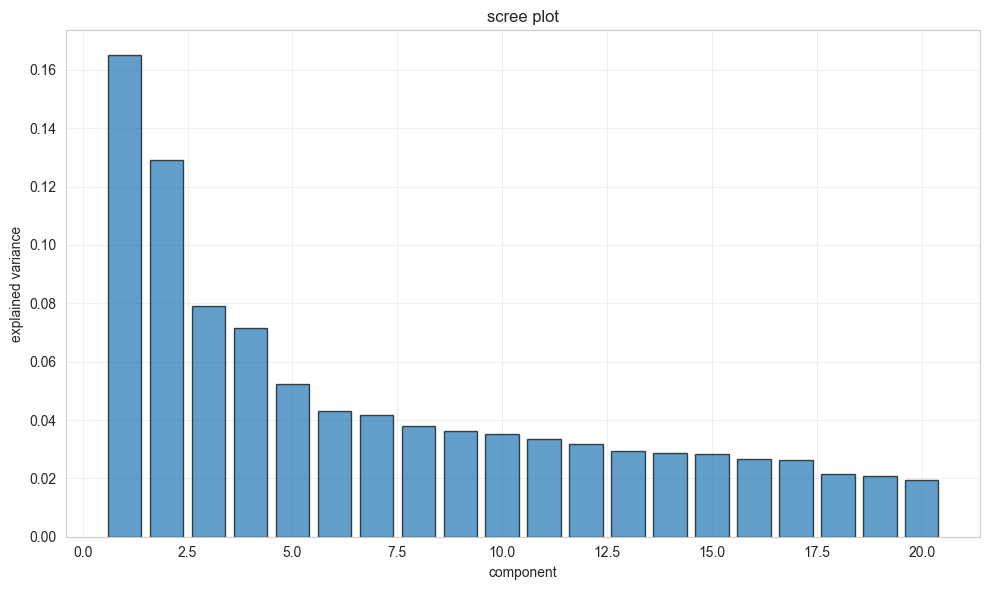

In [24]:
print("\n" + "=" * 60)
print("Method 1: PCA")
print("=" * 60)

#standardization
scaler_pca = StandardScaler()
X_train_std = scaler_pca.fit_transform(X_train)
X_test_std = scaler_pca.transform(X_test)

#pca
pca_full = PCA()
pca_full.fit(X_train_std)

#explained variance
var_exp = pca_full.explained_variance_ratio_
var_cum = np.cumsum(var_exp) #cumulative explained variance

#number of components
n_comp_95 = np.argmax(var_cum >= 0.95) + 1
n_comp_90 = np.argmax(var_cum >= 0.90) + 1

print(f"\nPCA results")
print(f"components for 90% variance: {n_comp_90}/{X.shape[1]}")
print(f"components for 95% variance: {n_comp_95}/{X.shape[1]}")
print(f"possible reduction: {(1 - n_comp_95/X.shape[1])*100:.1f}%")

#screeplot
plt.figure(figsize=(10, 6))
plt.bar(range(1, min(21, len(var_exp)+1)), var_exp[:20], alpha=0.7, edgecolor='black')
plt.title("scree plot")
plt.xlabel("component")
plt.ylabel("explained variance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This scree plot displays the explained variance for the first 20 components of the PCA performed on the standardized Paris dataset. The first two components are the most significant, accounting for approximately 16.5% and 13% of the variance respectively, suggesting that the primary differences between Paris listings are captured in these initial dimensions. The elbow appears at component 5, although in order to capture at least 95% of the information we need the first 20 principal components.

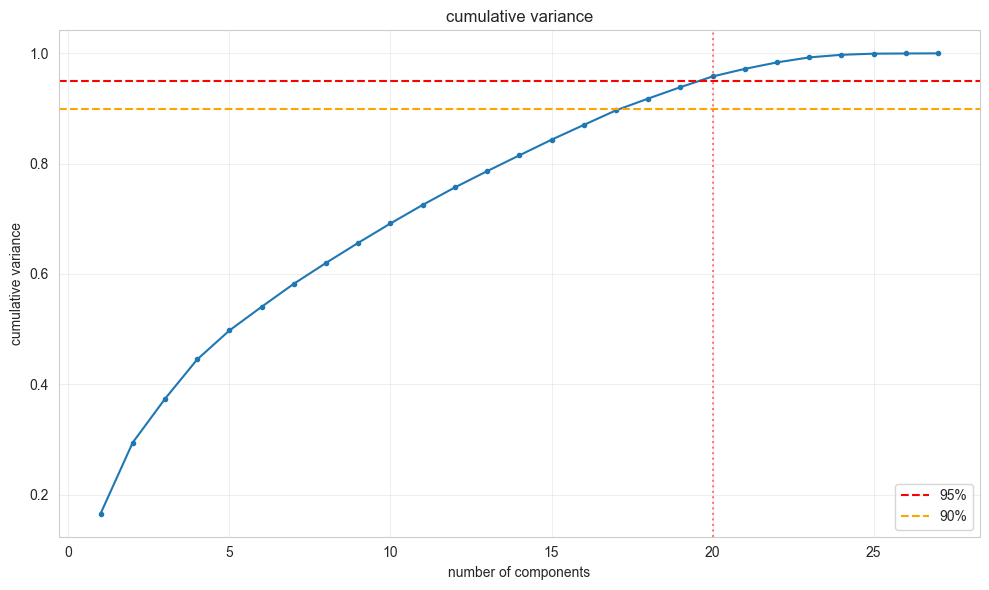

In [ ]:
#cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_cum)+1), var_cum, marker='o', markersize=3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90%')
plt.axvline(x=n_comp_95, color='r', linestyle=':', alpha=0.5)
plt.title("cumulative variance")
plt.xlabel("number of components")
plt.ylabel("cumulative variance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The cumulative variance plot shows the "cost" of dimensionality reduction: while the first few components capture the main trends, you need 20 components to retain 95% of the original information as found previously. To avoid losing significant detail about the listings, a model should likely use at least the first 20 components.

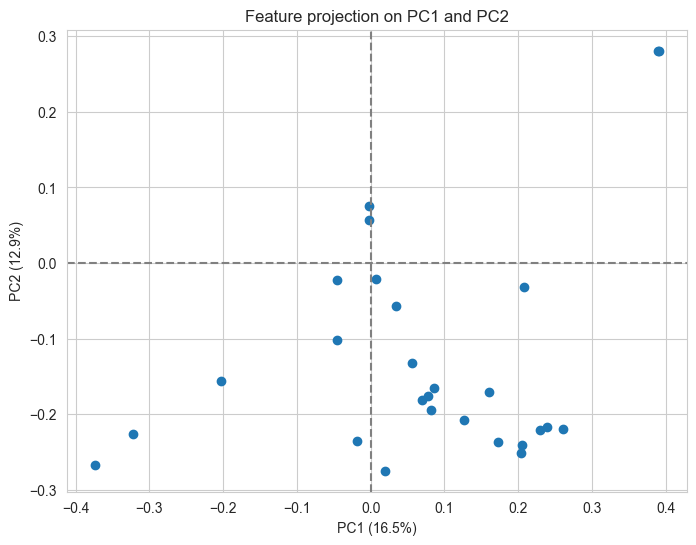

In [26]:
#plot features projection on PC1 and PC2 axes
plt.figure(figsize=(8,6))
plt.scatter(pca_full.components_[0], pca_full.components_[1])
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
pc1_pct = pca_full.explained_variance_ratio_[0]*100
pc2_pct = pca_full.explained_variance_ratio_[1]*100
plt.xlabel(f'PC1 ({pc1_pct:.1f}%)')
plt.ylabel(f'PC2 ({pc2_pct:.1f}%)')
plt.title('Feature projection on PC1 and PC2')
plt.show()

Features far to the right or left on the PC1 axis are the primary drivers of listing diversity that in this case will certainly be the size, while those high or low on PC2 represent secondary characteristics, which are mainly grouped in the lower half. The isolation of certain points suggests specific attributes that represent unique units, such as the outlier in the top-right quadrant which likely represents a specific listing category that scales uniquely with both components.

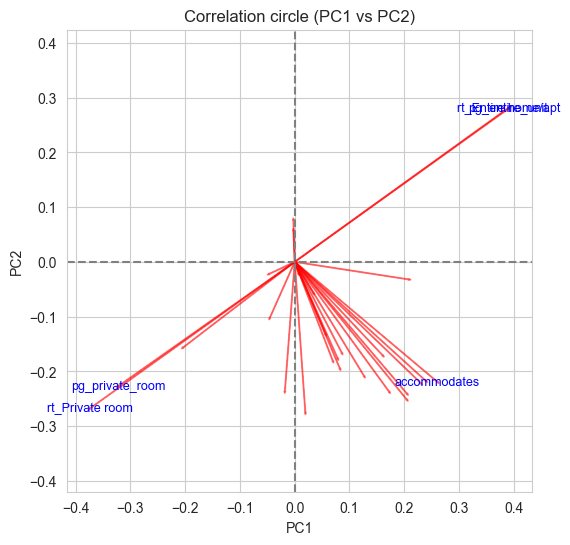

In [27]:
#correlation circle for PC1 and PC2 
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
vecs = pca_full.components_[:2]
corrs = np.linalg.norm(vecs, axis=0)
top_idx = np.argsort(corrs)[-5:] #top 5 features with highest correlation to PC1/PC2
for i in range(len(X.columns)):
    plt.arrow(0, 0, vecs[0,i], vecs[1,i], color='r', alpha=0.5)
for i in top_idx:
    plt.text(vecs[0,i], vecs[1,i], X.columns[i], fontsize=9, ha='center', va='center', color='blue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Correlation circle (PC1 vs PC2)')
plt.axis('equal')
plt.show()

This correlation circle explicitly labels the variables driving the PCA, revealing a clear opposition in the Paris market: "rt_Entire home/apt" correlates positively with both PC1 and PC2, while "rt_Private room" and "pg_private_room" show a strong negative correlation. This indicates that the first two components effectively distinguish between renting an entire unit versus a private room. Variables like "accommodates" cluster in the lower-right, showing that listing capacity is a major factor in PC1 but moves inversely to the factors driving PC2.


 top 10 features PC1:
            feature  loading
 rt_Entire home/apt 0.390591
     pg_entire_unit 0.389621
    rt_Private room 0.373965
    pg_private_room 0.321908
       accommodates 0.260369
 score_chef_kitchen 0.239377
     has_dishwasher 0.230193
has_washing_machine 0.207927
               beds 0.204739
           bedrooms 0.204361

 top 10 features PC2:
           feature  loading
    pg_entire_unit 0.280815
rt_Entire home/apt 0.280051
  standing_thermal 0.274720
   rt_Private room 0.267624
          bedrooms 0.251118
              beds 0.240387
     bathrooms_qty 0.236820
            has_ac 0.235758
   pg_private_room 0.226700
    has_dishwasher 0.221277


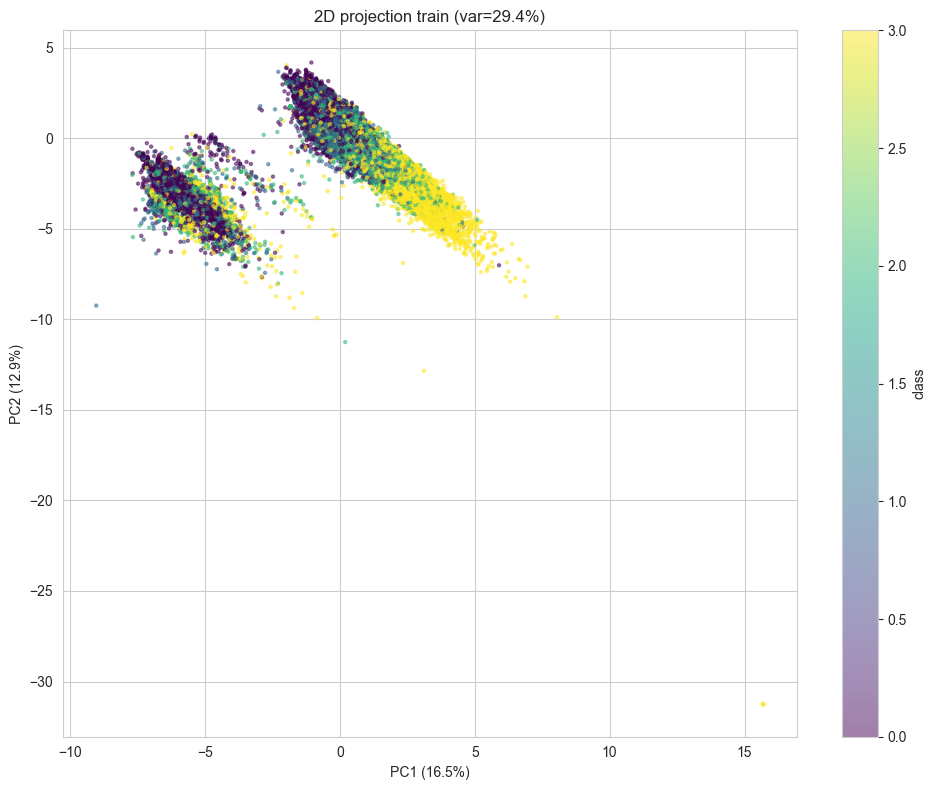

In [28]:
#2D projection
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_std)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], 
                     c=y_train, cmap='viridis', s=5, alpha=0.5)
plt.title(f"2D projection train (var={pca_2d.explained_variance_ratio_.sum():.1%})")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})")
plt.colorbar(scatter, label='class')
plt.tight_layout()

#feature importance PC1
pc1_loadings = pd.DataFrame({
    'feature': X.columns,
    'loading': np.abs(pca_full.components_[0])
}).sort_values('loading', ascending=False)

print(f"\n top 10 features PC1:")
print(pc1_loadings.head(10).to_string(index=False))

#feature importance PC2
pc2_loadings = pd.DataFrame({
    'feature': X.columns,
    'loading': np.abs(pca_full.components_[1])
}).sort_values('loading', ascending=False)

print(f"\n top 10 features PC2:")
print(pc2_loadings.head(10).to_string(index=False))

PC1 represents a "scale" axis that separates the Paris market by rental type and capacity. The top features Entire home/apt and Private room drive the distinct two cluster split seen in the 2D projection. This confirms that the listing's target_class is fundamentally determined by whether the property is a large, fully-equipped unit or a smaller shared space.

The projection maps the individual listings into PC space, color coded by their target_class. The distinct separation into two clusters, a dense group on the left and an elongated group on the right proves that PC1 is highly effective at identifying structural differences between listing types. The color gradient shows that higher class values (yellow) are predominantly located in the right-hand cluster, suggesting that the features with high PC1 loadings (like "entire home" or "accommodates") are the strongest predictors of the listing's class.